In [1]:
import pickle
import shutil

import numpy as np
import matplotlib.pyplot as plt

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc

import os
import glob

from emcee.autocorr import integrated_time
import pandas as pd
from chainconsumer import ChainConsumer, Chain, Truth

from time import perf_counter

%load_ext autoreload
%autoreload 2

## Load pulsars and PTA object

In [2]:
# load Enterprise pulsar objects
with open('ent_data_simulation/data/enterprise_pulsars.pkl', 'rb') as f:
    psrs = pickle.load(f)

# load Enterprise PTA object
with open('ent_data_simulation/data/pta.pkl', 'rb') as f:
    pta = pickle.load(f)

for psr in psrs:
    print(psr.name)

J0645+5158
B1855+09
J1843-1113
J0557+1551
J1730-2304
J1643-1224
J1022+1001
J1910+1256
J0740+6620
J1832-0836
J1811-2405
J0030+0451
J0509+0856
J0340+4130
B1953+29
J1744-1134
B1937+21
J1719-1438
J0605+3757
J1903+0327


In [3]:
# load injected parameters
data_dict = np.load('ent_data_simulation/data/data_dict.npz', allow_pickle=True)
x_inj_dict = data_dict['x_inj'].item()

In [4]:
print(pta.summary())

enterprise v3.3.3,  Python v3.10.14

Signal Name                              Signal Class                   no. Parameters      
J0645+5158_linear_timing_model_svd       TimingModel                    0                   

params:
__________________________________________________________________________________________
J0645+5158_measurement_noise             MeasurementNoise               0                   

params:
__________________________________________________________________________________________
J0645+5158_gw                            FourierBasisCommonGP           2                   

params:
log10_A_gw:Uniform(pmin=-30.0, pmax=-10.0)                                                
gamma_gw:Uniform(pmin=0.1, pmax=20.0)                                                     
__________________________________________________________________________________________
B1855+09_linear_timing_model_svd         TimingModel                    0                   

params:
_______

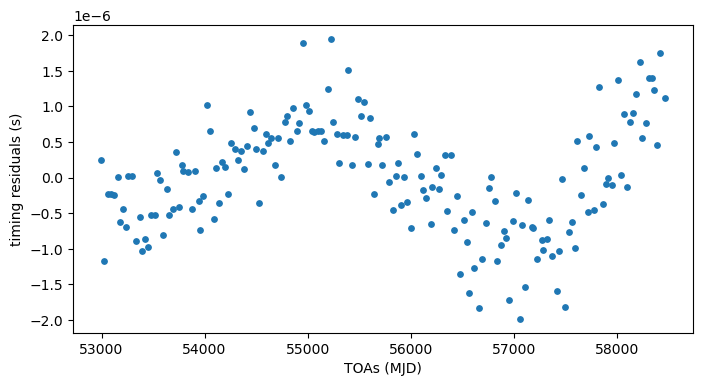

In [5]:
# plot timing residuals
psr_ndx = 0
plt.figure(figsize=(8, 4))
plt.scatter(psrs[psr_ndx].toas / 86400., psrs[psr_ndx].residuals, s=15)
plt.xlabel('TOAs (MJD)')
plt.ylabel('timing residuals (s)')
plt.show()

## test Enterprise likelihood

In [6]:
def get_dict(params):
    return {param_name: param for param_name, param in zip(pta.param_names, params)}

In [7]:
# likelihood function
def get_lnlike(params):
    return pta.get_lnlikelihood(get_dict(params))

# prior function
def get_lnprior(params):
    return pta.get_lnprior(get_dict(params))

# posterior
def get_lnpost(params):
    return get_lnprior(params) + get_lnlike(params)

In [8]:
x_test = np.array([param.sample() for param in pta.params])
print(get_lnpost(x_test))

39006.91414712331


In [9]:
%timeit get_lnpost(x_test)

16.8 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
# store injected parameters in array
x_inj = []
for param_name in pta.param_names:
    print(f'{param_name} = {x_inj_dict[param_name]}')
    if param_name[-6:] == 'p_dist':  # pulsar distances are normalized
        x_inj.append(0.)
    else:
        x_inj.append(x_inj_dict[param_name])
x_inj = np.array(x_inj)

gamma_gw = 4.333333333333333
log10_A_gw = -14.5


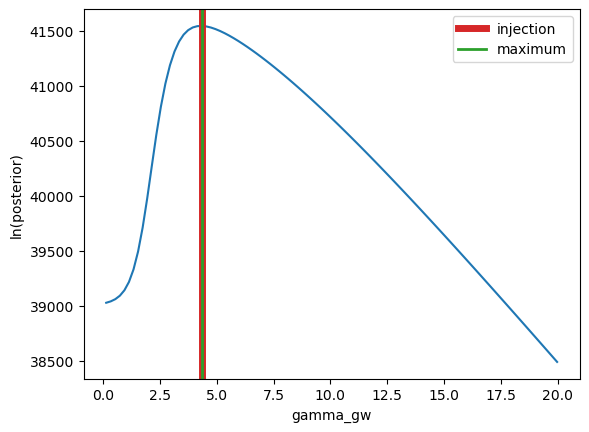

In [11]:
# plot cross-sections of posterior
param_ndx = 0
num_evals = 100
# get "minimum" and "maximum" of parameter values
param_samples = np.array([pta.params[param_ndx].sample() for _ in range(1000)])
param_vals = np.linspace(np.min(param_samples), np.max(param_samples), num_evals)
x_vals = np.tile(x_inj, (num_evals, 1))
x_vals[:, param_ndx] = param_vals
lnposts = np.array([get_lnpost(x) for x in x_vals])
plt.plot(param_vals, lnposts)
plt.axvline(x_inj[param_ndx], color='C3', label='injection', lw=5)
plt.axvline(param_vals[np.argmax(lnposts)], color='C2', label='maximum', lw=2)
plt.legend()
plt.xlabel(pta.param_names[param_ndx])
plt.ylabel('ln(posterior)')
plt.show()

## load MCMC samples

In [12]:
# store injected parameters in array
x_inj = []
for param_name in pta.param_names:
    print(f'{param_name} = {x_inj_dict[param_name]}')
    if param_name[-6:] == 'p_dist':  # pulsar distances are normalized
        x_inj.append(0.)
    else:
        x_inj.append(x_inj_dict[param_name])
x_inj = np.array(x_inj)


# set up the sampler:
ndim = len(x_inj)
cov = np.eye(ndim) * 5.0
# cov[-4] = 0.0001
outDir = 'enterprise_chains'

sampler = ptmcmc(ndim=ndim,
                 logl=get_lnlike,
                 logp=get_lnprior,
                 cov=cov, 
                 outDir=outDir,
                 resume=False)

# do MCMC
num_samples = int(1e5)
time_start = perf_counter()
sampler.sample(p0=x_inj,
               Niter=num_samples,
               # ladder=np.round(1.3**np.arange(4), 2),
               # writeHotChains=True,
               DEweight=20,
               SCAMweight=20,
               AMweight=5,
               # Tskip=300
               )
time_stop = perf_counter()

gamma_gw = 4.333333333333333
log10_A_gw = -14.5
Finished 0.00 percent in 0.000677 s Acceptance rate = 0

/opt/anaconda3/envs/PTA-x86/lib/python3.10/site-packages/enterprise/signals/parameter.py:62: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 10.00 percent in 166.207014 s Acceptance rate = 0.50112Adding DE jump with weight 20
Finished 100.00 percent in 1744.585692 s Acceptance rate = 0.51655
Run Complete


In [13]:
folder = 'enterprise_chains'

# Find all files matching chain_*.txt
files = glob.glob(os.path.join(folder, "chain_*.txt"))

# Extract temperatures from filenames
def get_temp(fname):
    base = os.path.basename(fname)
    temp_str = base.replace("chain_", "").replace(".txt", "")
    return float(temp_str)

# load chains
files_sorted = sorted(files, key=get_temp)
chains = [np.loadtxt(f) for f in files_sorted]
ladder = [get_temp(f) for f in files_sorted]

# make pandas data frame for each chain
dfs = []
lnlikes = []
for chain, temp in zip(chains, ladder):
    dfs.append(pd.DataFrame(chain[:, :len(pta.param_names)], columns=pta.param_names))
    lnlikes.append(chain[:, -3])

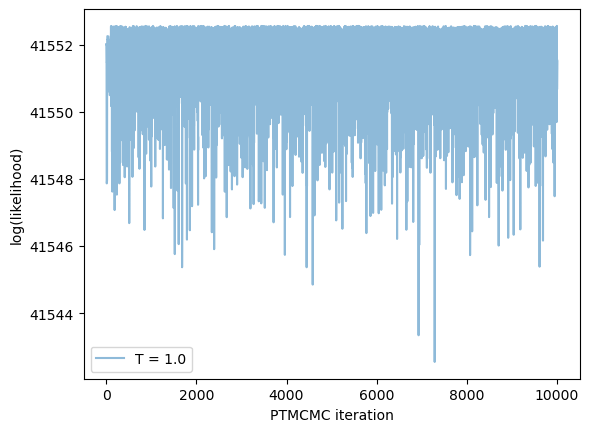

In [26]:
_ = [plt.plot(lnlike, color=f'C{i}', label=f'T = {temp}', alpha=0.5)
     for i, (lnlike, temp) in enumerate(zip(lnlikes[::-1], ladder[::-1]))]
plt.xlabel('PTMCMC iteration')
plt.ylabel('log(likelihood)')
plt.legend()
plt.show()

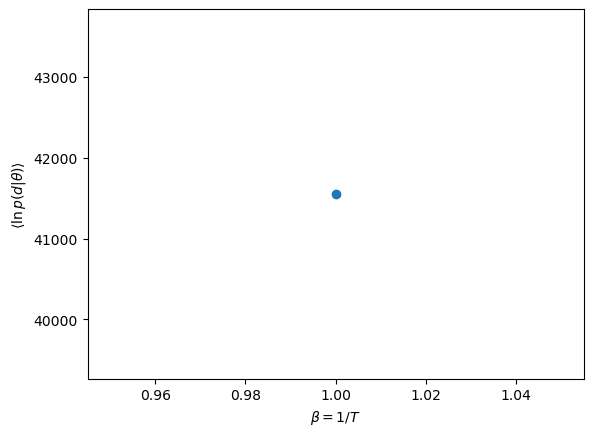

In [27]:
# illustrate thermodynamic integration
burnin = 200
betas = 1. / np.array(ladder)
plt.plot(betas, [np.mean(lnlike[burnin:], axis=0)
                 for lnlike in lnlikes], ls='--', marker='o')
plt.xlabel(r'$\beta = 1 / T$')
plt.ylabel(r'$\langle \ln p(d | \theta) \rangle$')
plt.show()

In [28]:
# param_ndxs = np.r_[20:28]
# c = ChainConsumer()
# for df, temp in zip(dfs, ladder):
#     c.add_chain(Chain(samples=df.iloc[0:, param_ndxs], name=f'T = {temp}'))
# c.add_truth(Truth(location=x_inj_dict))
# fig = c.plotter.plot()

In [29]:
int_time = np.max(integrated_time(dfs[0].iloc[burnin:], has_walkers=False))
effective_sample_size = np.round(dfs[0].iloc[burnin:].shape[0] / (2. * int_time))
duration = time_stop - time_start
ESS_per_sec = effective_sample_size / duration
print(f'effective sample size / sec = {ESS_per_sec}')

effective sample size / sec = 1.3395438837986444


In [30]:
# save data frame for T = 1 chain
dfs[0].iloc[burnin:].to_pickle("ent_df.pkl.gz", compression="gzip")